# Challenge Part 2: Sentiment Classifier

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

Having already trained the language model, it is time to use it for the actual task!

In [3]:
VERSION = 'v1'

DATA_PATH = 'data/%s/' % VERSION

import os
os.makedirs(DATA_PATH, exist_ok=True)

## Loading the dataset

We will load the already pre-processed text data. However for the classification task, we only care about the strongly positive and negative examples, so we will filter out the neutral ones.

In [4]:
with open('data/lm/tweet_data.pkl', 'rb') as f:
    df = pickle.load(f)

df.groupby('sentiment').count()

,text
sentiment,
negative,9178
neutral,3099
positive,2363


In [5]:
df_labeled = df[df['sentiment'] != 'neutral']

df_labeled.groupby('sentiment').count()

,text
sentiment,
negative,9178
positive,2363


In [6]:
df_labeled.head(10)

,text,sentiment
1,plus you've added commercials to the experienc...,positive
3,"it's really aggressive to blast obnoxious "" en...",negative
4,and it's a really big bad thing about it,negative
5,seriously would pay $ 30 a flight for seats th...,negative
6,"yes , nearly every time I fly VX this “ ear wo...",positive
8,"Well , I didn't … but NOW I DO ! :-D",positive
9,"it was amazing , and arrived an hour early . Y...",positive
11,I <3 pretty graphics . so much better than min...,positive
12,This is such a great deal ! Already thinking a...,positive
13,xxhan I'm flying your fabulous Seductive skies...,positive


Let's create the DataBunch for the classification task:

In [7]:
bs = 48

data_lm = load_data(path='data/lm', file='data_lm.pkl')

data_clas = (TextList.from_df(df_labeled, cols=['text'], vocab=data_lm.vocab, path=DATA_PATH)
           .split_by_rand_pct(valid_pct=0.1, seed=0)
           .label_from_df(cols='sentiment')
           .databunch(bs=bs))

data_clas.save('data_clas.pkl')

In [8]:
# show a few examples
data_clas.show_batch(10)

text,target
xxbos xxmaj the xxmaj fact xxmaj that u xxmaj see xxmaj black xxmaj history xxmaj month 12 xxmaj months a xxmaj year xxmaj is xxmaj xxunk ! xxmaj we xxup will xxup be xxmaj an xxmaj xxunk xxmaj base xxmaj for xxmaj corp . xxmaj like u xxmaj in xxmaj future !,positive
xxbos xxup xxunk u xxup us xxup airways xxup with xxup yo xxup shitty xxup chicken xxup xxunk xxup xxunk xxup that xxup so xxup xxunk xxup and u xxup xxunk xxup make xxup me xxup wait xxup in a 6 xxup hr xxup layover xxup xxunk u xxup and,negative
"xxbos our ft xxunk xxup xxunk / xxup dfw ( w / cx to xxup lga ) tomorrow xxmaj cancelled xxmaj flighted , 4 hrs so far waiting for call back . xxmaj what should we do ? xxmaj need to get to nyc",negative
xxbos xxup mia - xxup ewr # xxunk 😄 😄 😄 excellent crew . xxup ewr - xxup iad # xxunk 😡 😡 😡 xxmaj no crew to load bags - waiting w / door open freezing . 20 mins past departure .,negative
"xxbos xxmaj cancelled xxmaj flights flt from xxup ewr . "" xxmaj no crew "" . xxmaj tells wife & 4 yr old to "" get to xxup ny to catch xxhan "" to xxup yyz ! xxmaj good customerservice is dead .",negative
"xxbos xxmaj thanks . xxmaj still booked our trip 3 / xxunk 17 xxup lb to xxup slc to see grand kids . xxmaj just very frustrating . xxmaj tried app , web , etc . xxmaj still love u guys !",positive
"xxbos i know . i ’ m sure you hear it all the time — don ’ t like the new seats . i ’ m a small guy , 5 ’ 6 ” and i feel the new planes are tight",negative
"xxbos file loc : xxup xxunk . xxmaj bag at airport since last xxunk . xxmaj not "" scheduled "" to get xxup xxunk xxunk xxunk 8 ? xxup why ? u xxunk b ashamed . i 'm disgusted w / u",negative
xxbos xxmaj hi ! xxmaj just got my xxup tsa pre - check # & put it in my acct . xxmaj but it 's not on my boarding pass for a flight this xxunk . xxmaj can it be updated ?,negative
xxbos xxmaj step 1 : xxmaj cancelled xxmaj flight flight . xxmaj step 2 : xxmaj do n't notify customer . xxmaj step 3 : xxmaj charge them for food while they try to xxunk their wait . xxmaj brilliant .,negative


Let's finally create the classifier, that will take the already fine-tuned encoder from the previous part.

In [9]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, path=DATA_PATH)
# a trick to be able to load from another folder...
learn.path = Path('data/lm')
learn.load_encoder('fine_tuned_enc')
learn.path = Path(DATA_PATH)

In [10]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.91E-02
Min loss divided by 10: 3.02E-02


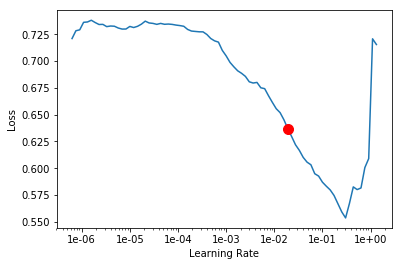

In [11]:
learn.recorder.plot(suggestion=True)

In [12]:
learn.fit_one_cycle(1, 7e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.305959,0.219657,0.909879,00:07


In [13]:
learn.save('first')
learn.load('first');

In [14]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(3.5e-3/(2.6**4),3.5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.314687,0.176379,0.938475,00:08


In [15]:
learn.save('second')
learn.load('second');

In [16]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1.75e-3/(2.6**4),1.75e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.261840,0.176202,0.937608,00:13


In [17]:
learn.save('third')
learn.load('third');

In [18]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(3.5e-4/(2.6**4),3.5e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.234114,0.163529,0.935875,00:19
1,0.204991,0.156370,0.940208,00:19


In [19]:
learn.predict("Awful flight")

(Category negative, tensor(0), tensor([0.8894, 0.1106]))

In [20]:
learn.predict("Great trip, thanks to all")

(Category positive, tensor(1), tensor([0.0167, 0.9833]))

In [21]:
learn.predict("attendant was rude!")

(Category negative, tensor(0), tensor([0.5946, 0.4054]))

In [22]:
learn.predict("I thought I was going to have some great vacations, but everything was ruined by the delay and the rude service. Way, to go @VirginAmerica!")

(Category negative, tensor(0), tensor([0.8751, 0.1249]))

In [26]:
learn.predict("first time with you, pretty fair :-) Food was ok")

(Category positive, tensor(1), tensor([0.4743, 0.5257]))

In [29]:
learn.validate(data_clas.valid_dl)

[0.15637034, tensor(0.9402)]

In [30]:
learn.validate(data_clas.train_dl)

[0.12410642, tensor(0.9530)]